![](https://images.pexels.com/photos/532192/pexels-photo-532192.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)

# Wind power forecasting
Wind energy is the energy of the wind transformed into useful energy through wind turbines. This renewable energy source is widely used because it is an alternative to fossil energy, it is clean, does not produce greenhouse gases and can generally be used in various locations, however there are still some environmental and social problems attached, such as soil compaction and the noise emitted by the blades. In addition, wind energy suffers a lot from the fluctuation of winds and, therefore, doors are opened for the application of Machine Learning models to be used to make generation forecasts. Finally, this project aims to forecast the wind power generation of a wind turbine located in Germany with historical data from 2011 to the end of 2021.

# Dictionary (Column)
- dt: Time series with timestep of 15 minutes.
- MW: Wind power (MW).
   
# References
- [kaggle dataset](https://www.kaggle.com/datasets/l3llff/wind-power)
- https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21


### 1) Importing Libraries and Data loading

In [41]:
# Importing Libraries:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly as pl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display

from sklearn.feature_selection import r_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Conv1D,  MaxPooling1D

import os
import joblib
from datetime import datetime as dt

In [2]:
# Loading dataset
df = pd.read_csv("data.csv")

In [3]:
# Copy of the dataset:
dado_horarios = df.copy()

### 2) Exploratory Data Analysis

In [4]:
# Let's see the first five rows:
dado_horarios.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [5]:
# Some information about data type and memory:
dado_horarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt      385566 non-null  object 
 1   MW      385566 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB


In [6]:
# Changing the type of the Time series column:
dado_horarios['dt'] = pd.to_datetime(dado_horarios['dt'])

In [7]:
# Dt column as index:
dado_horarios.set_index('dt', inplace=True)

In [8]:
# Some decriptive statistics:
dado_horarios.describe()

,MW
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [9]:
# Missing data:
dado_horarios.isna().sum()

MW    0
dtype: int64

As we can see above, there is no missing data.

In [10]:
# Aggregating information:
dado_horarios['month'] = dado_horarios.index.month
dado_horarios['year'] = dado_horarios.index.year

group = dado_horarios.groupby(["year", "month"]).mean().reset_index()

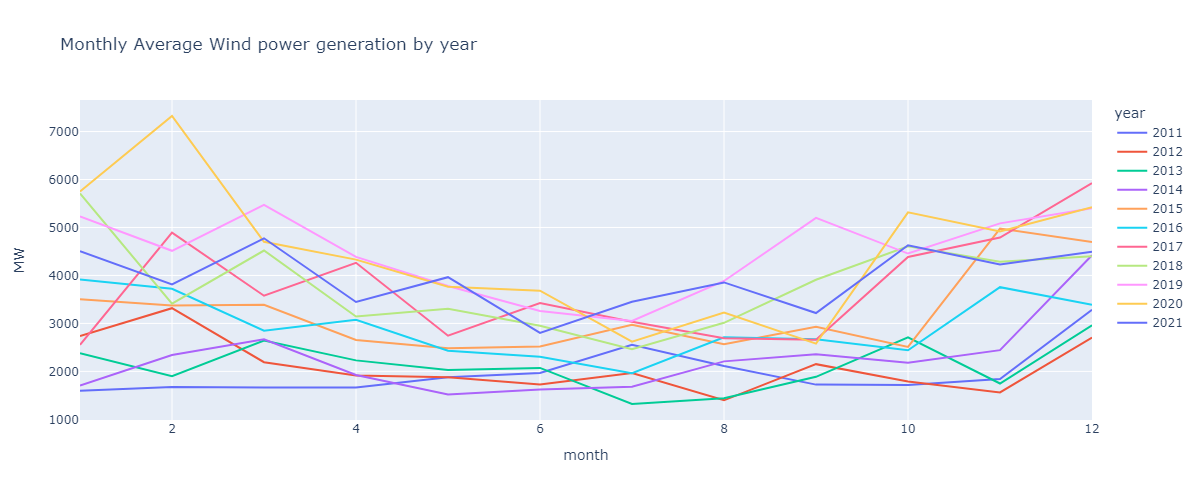

In [11]:
# Ploting the monthly average Wind Power by year:
fig = px.line(data_frame=group, x='month', y='MW', color='year', title="Monthly Average Wind power generation by year")
fig.show("png", width=1200, height=500)

Observations:
- Compared to the average energy produced in 2011, the energy produced in 2021 is much bigger for every month.


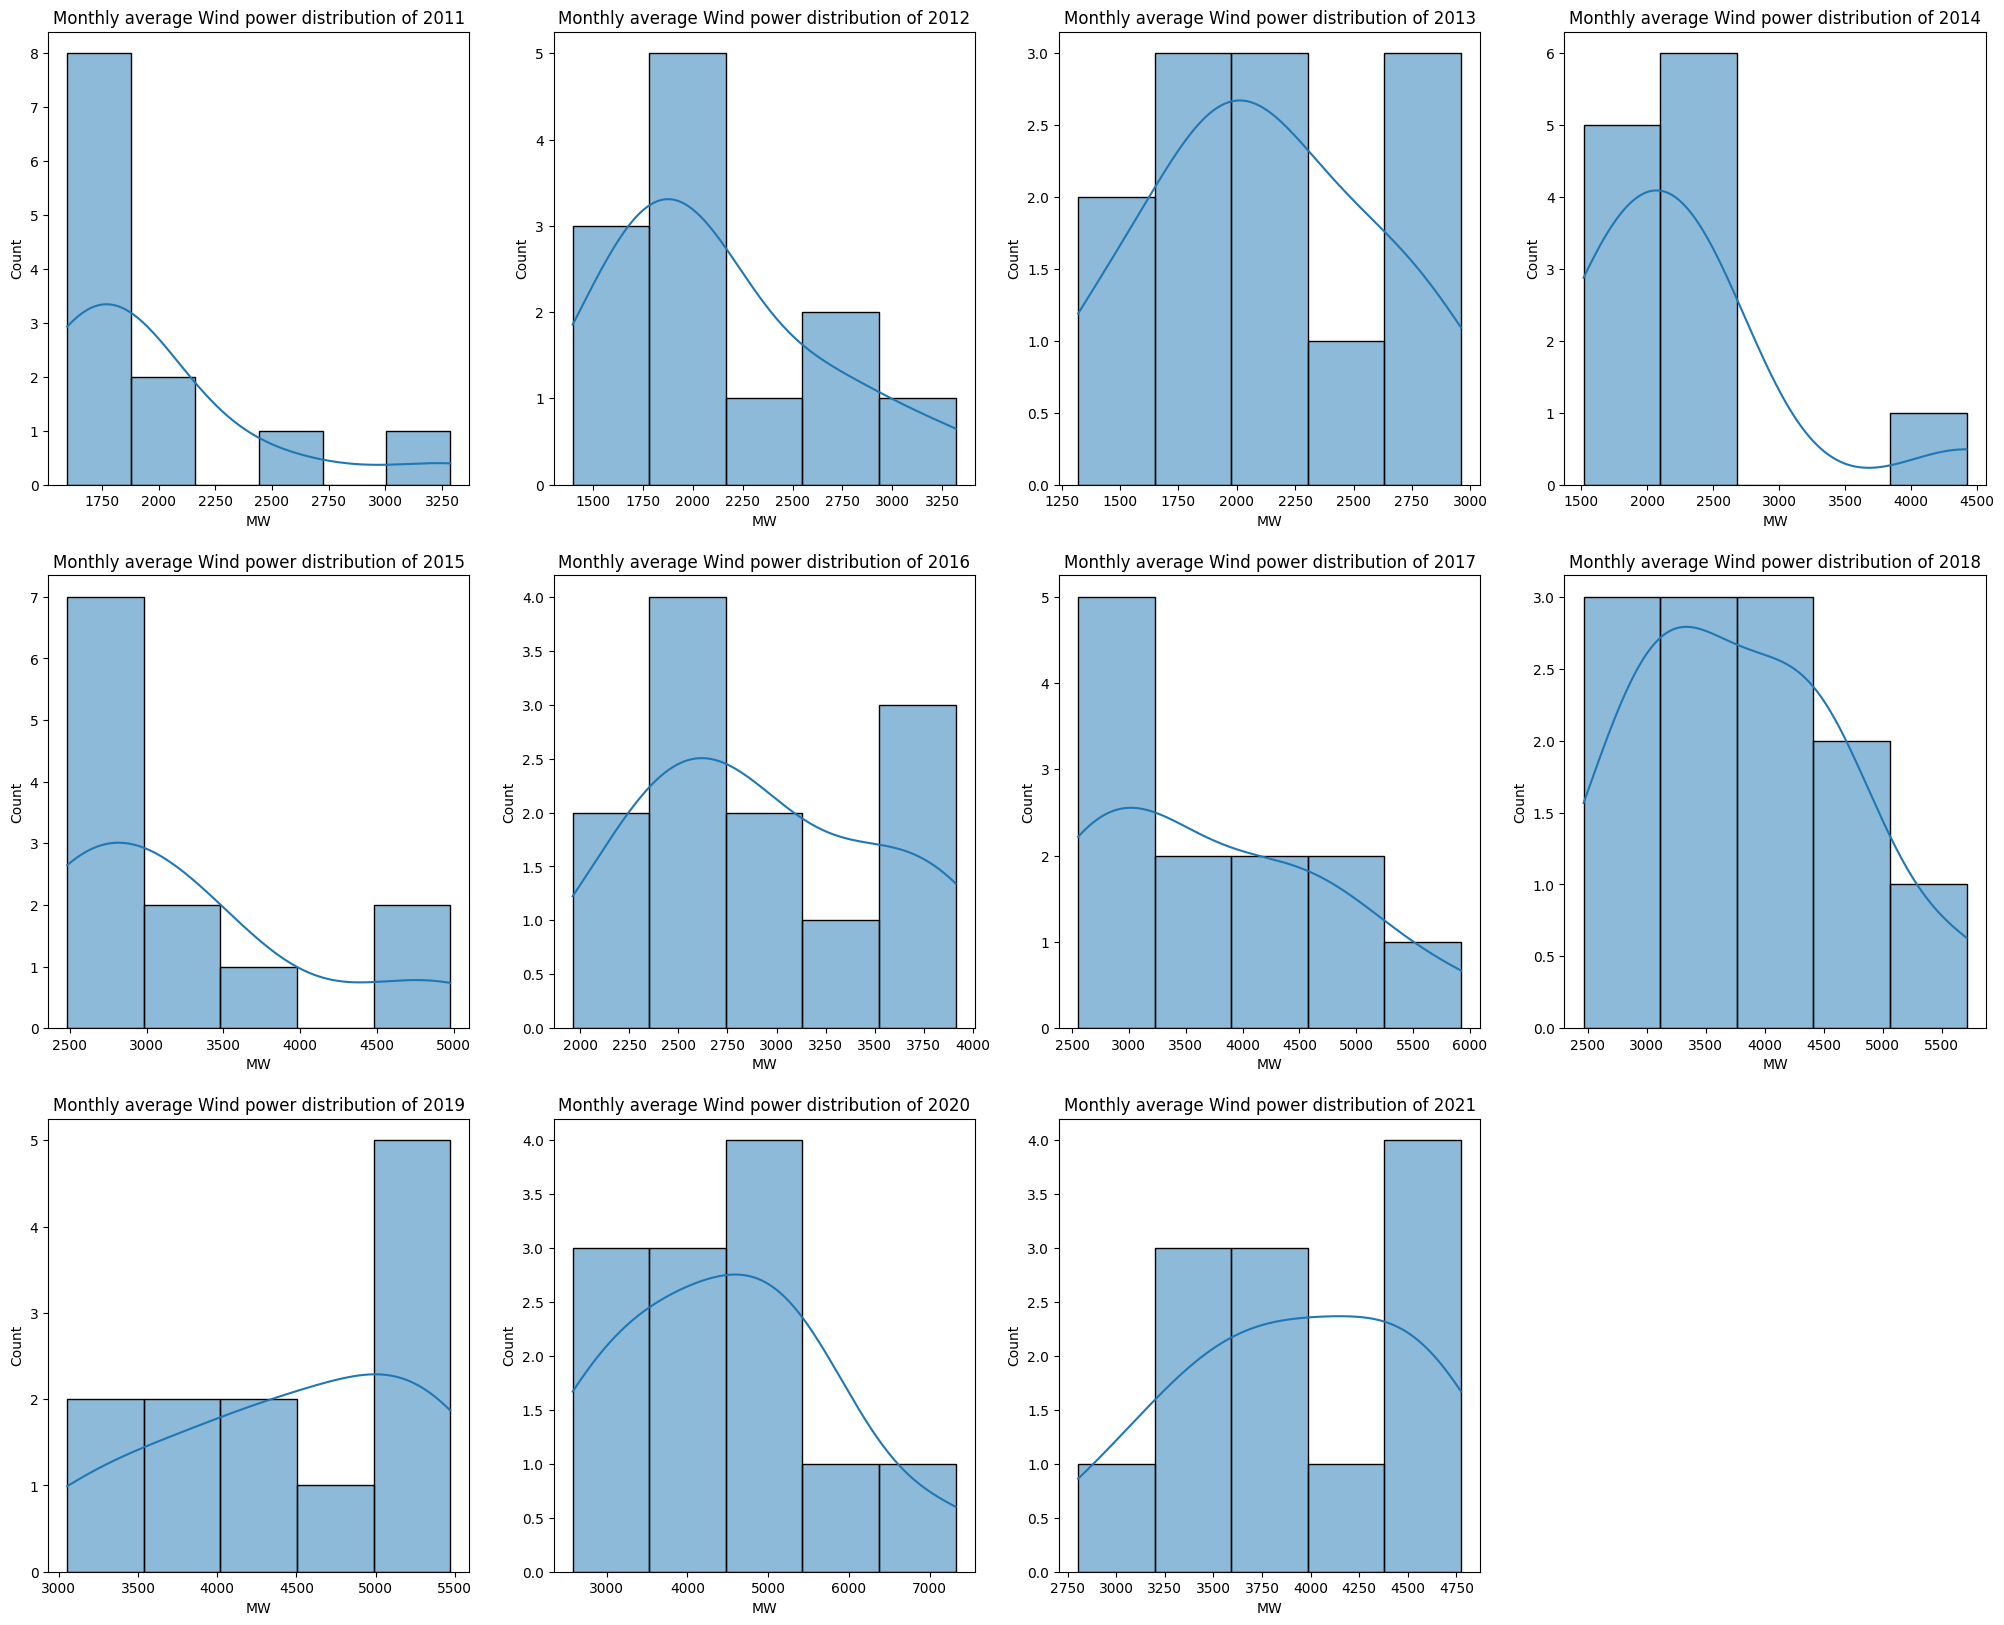

In [12]:
# Histograma da série temporal:
fig, ax = plt.subplots(ncols=4, nrows=3, sharex=False, sharey=False, figsize=(25, 20))

sns.histplot(x=group[group['year'] == 2011]['MW'], kde=True, ax=ax[0, 0])
sns.histplot(x=group[group['year'] == 2012]['MW'], kde=True, ax=ax[0, 1])
sns.histplot(x=group[group['year'] == 2013]['MW'], kde=True, ax=ax[0, 2])
sns.histplot(x=group[group['year'] == 2014]['MW'], kde=True, ax=ax[0, 3])
sns.histplot(x=group[group['year'] == 2015]['MW'], kde=True, ax=ax[1, 0])
sns.histplot(x=group[group['year'] == 2016]['MW'], kde=True, ax=ax[1, 1])
sns.histplot(x=group[group['year'] == 2017]['MW'], kde=True, ax=ax[1, 2])
sns.histplot(x=group[group['year'] == 2018]['MW'], kde=True, ax=ax[1, 3])
sns.histplot(x=group[group['year'] == 2019]['MW'], kde=True, ax=ax[2, 0])
sns.histplot(x=group[group['year'] == 2020]['MW'], kde=True, ax=ax[2, 1])
sns.histplot(x=group[group['year'] == 2021]['MW'], kde=True, ax=ax[2, 2])
ax[2, 3].set_visible(False)


ax[0, 0].set_title("Monthly average Wind power distribution of 2011")
ax[0, 1].set_title("Monthly average Wind power distribution of 2012")
ax[0, 2].set_title("Monthly average Wind power distribution of 2013")
ax[0, 3].set_title("Monthly average Wind power distribution of 2014")
ax[1, 0].set_title("Monthly average Wind power distribution of 2015")
ax[1, 1].set_title("Monthly average Wind power distribution of 2016")
ax[1, 2].set_title("Monthly average Wind power distribution of 2017")
ax[1, 3].set_title("Monthly average Wind power distribution of 2018")
ax[2, 0].set_title("Monthly average Wind power distribution of 2019")
ax[2, 1].set_title("Monthly average Wind power distribution of 2020")
ax[2, 2].set_title("Monthly average Wind power distribution of 2021")

plt.show()

Observations:
- These distributions do not seem to follow a normal distribution.

In [13]:
# Setting the time series column as index:
df.set_index('dt', inplace=True)

## 3) Preprocessing

The Class below has a method that can transform a dataset with a Time series structure into a dataset that can be used in a supervised manner.

In [14]:
# Proprocessing class 
class Preprocessamento:

    def timeseries_to_supervised(self, df, n_features, n_target):
        n_linhas = 0
        colunas_features = ['var(t - {})'.format(str(i)) for i in range(n_features, -1, -1) if i != 0]
        colunas_target = ['var(t)' if i==0 else 'var(t + {})'.format(str(i)) for i in range(0, n_target)]
        colunas_total = colunas_features + colunas_target
        lista=[]
        
        while n_linhas <= len(df) - n_target - n_features:
            quantidade_de_features_iteracao = df.iloc[n_linhas:n_linhas + n_features].values
            quantidade_de_target_iteracao = df.iloc[n_linhas + n_features: n_linhas + n_features + n_target]
            
            linha = np.concatenate([quantidade_de_features_iteracao, quantidade_de_target_iteracao], axis=0)
            linha_reshape = linha.reshape(1, -1)
            lista.append(linha_reshape[0])
    
            n_linhas += 1
        df_iter = pd.DataFrame(lista, columns=colunas_total)

        return df_iter


In [15]:
# Function that can plot several metrics:
def metricas(y_test, y_pred):
      
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    coef_pearson = r_regression(y_pred.reshape(-1, 1), y_test)[0]
    print(f'Mean squared error: {mse}')
    print(f'Root Mean squared error: {rmse}')
    print(f'Coef de pearson: {coef_pearson}')
    print('###########################################\n')
    return mse, rmse, coef_pearson

In [16]:
# Splitting into train an test datasets:
percentagem_treino_inicial = 0.8

limite_treino_inicial = int(len(df)*percentagem_treino_inicial)
df_train_inicial = df.iloc[0:limite_treino_inicial]
df_test = df.iloc[limite_treino_inicial:]

In [17]:
# Splitting into training and validation datasets:
percentagem_treino = 0.8

limite_treino = int(len(df_train_inicial)*percentagem_treino)
df_train = df_train_inicial.iloc[0:limite_treino]
df_val = df_train_inicial.iloc[limite_treino:]

In [18]:
# Intance of Preprocessing class:
prep_obj = Preprocessamento()

We will use a window of 20 and a horizon of 10. In other words, we are going to use 20 features to predict ten timesteps ahead in time. Furthemore, it is important to say that we will make a model for each timestep ahead, so it is going to be 10 models for each algorithm.

In [19]:
# Transforming the time series into a supervised problem:
n_features = 20
n_target = 10

df_train_supervised = prep_obj.timeseries_to_supervised(df_train, n_features, n_target)
df_val_supervised = prep_obj.timeseries_to_supervised(df_val, n_features, n_target)
df_test_supervised = prep_obj.timeseries_to_supervised(df_test, n_features, n_target)

In [20]:
# Some descriptive statistics about the features:
df_train_supervised.describe()

,var(t - 20),var(t - 19),var(t - 18),var(t - 17),var(t - 16),var(t - 15),var(t - 14),var(t - 13),var(t - 12),var(t - 11),...,var(t),var(t + 1),var(t + 2),var(t + 3),var(t + 4),var(t + 5),var(t + 6),var(t + 7),var(t + 8),var(t + 9)
count,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,...,246732.000000,246732.00000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000,246732.000000
mean,2629.614760,2629.621063,2629.621858,2629.621876,2629.622045,2629.622477,2629.622653,2629.622223,2629.621149,2629.619584,...,2629.571150,2629.56493,2629.558805,2629.552966,2629.546922,2629.541040,2629.534696,2629.528298,2629.521042,2629.513345
std,2577.736081,2577.739905,2577.740590,2577.740607,2577.740760,2577.741166,2577.741341,2577.740898,2577.739783,2577.738152,...,2577.683505,2577.67614,2577.668791,2577.661796,2577.654572,2577.647439,2577.639970,2577.632878,2577.624891,2577.616327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,...,710.000000,710.00000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
50%,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,...,1756.000000,1756.00000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000
75%,3720.270000,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000,...,3720.385000,3720.38500,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000,3720.385000
max,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,...,14266.070000,14266.07000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000


Observations:
- All of the features have approxmately the same mean and Standard Deviation.

In [21]:
# Splitting into train and test fetures and targets:
X_train, y_train = df_train_supervised.values[:, 0:n_features], df_train_supervised.values[:, n_features:]
X_val, y_val = df_val_supervised.values[:, 0:n_features], df_val_supervised.values[:, n_features:]
X_test, y_test = df_test_supervised.values[:, 0:n_features], df_test_supervised.values[:, n_features:]

In [22]:
# Features shape:
print('Feature shapes:')
print(f'Training: {X_train.shape}')
print(f'Validation: {X_val.shape}')
print(f'Test: {X_test.shape}')
print('#########################\n')

# Target shape:
print('Target shapes:')
print(f'Training: {y_train.shape}')
print(f'Validation: {y_val.shape}')
print(f'Test: {y_test.shape}')


Feature shapes:
Training: (246732, 20)
Validation: (61662, 20)
Test: (77085, 20)
#########################

Target shapes:
Training: (246732, 10)
Validation: (61662, 10)
Test: (77085, 10)


### 3.1) Data transformation

#### 3.1.1) Standard Scale

Definition:
- The Standard Scaler is a technique that rescales the distribution of a variable so that the mean of the observed sample is 0 and the standard deviation is 1. It is particularly useful for algorithms that rely on distance measures, such as K-means and K-nearest neighbors (KNN). Additionally, it is a recommended choice for algorithms based on neural networks.

OBS: Standard Scaler can perform slightly worst than the other transformations because it assumes that the data is normally distributed. However you can still standardize your data.

Matematical Definition:

$X_{new_{i}} = \frac{X_{i} - \hat{\mu}_{i}}{\sigma_{i}}$

- $\mu:$ Mean of the sample.
- $\sigma:$ Standard Deviation of the sample.

In [23]:
# Fitting a Standard Scaler object:
std_scaler = StandardScaler()
std_scaler.fit(X_train)

# Transforming all the sets:
X_train_std = std_scaler.transform(X_train) 
X_val_std = std_scaler.transform(X_val)
X_test_std = std_scaler.transform(X_test)

## 4) Fitting models

In [24]:
# Create nested directories: 
def make_directory(path):
    try:
        os.makedirs(path)
    except FileExistsError:
        print("File already exists!")


def save_models(model, path, name):
    path_extension = path + '/' + name + '.joblib'
    try:
        joblib.dump(model, path_extension)
    except:
        os.makedirs(path)
        joblib.dump(model, path_extension)


### 4.1) Multilayer Neural Network

In [26]:
# Function that structure a simple neural network architecture:
def mlp_simples(device):

    with tf.device(device):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='relu', input_shape=X_train.shape[1:]),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
        
    return model

In [30]:
# Making a directory for MLP models:
path_modelos_mlp_simples = "modelos_mlp_simples"
make_directory(path_modelos_mlp_simples)

# Training a MLP:
for target in range(n_target):
    
    # EarlyStopping callback:
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    checkpoint_mlp = tf.keras.callbacks.ModelCheckpoint('{}/model{}_mlp.h5'.format(path_modelos_mlp_simples, target))
    model_mlp = mlp_simples('/device:GPU:0')
    history_2 = model_mlp.fit(X_train_std, y_train[:, target], epochs=60,
                    validation_data=(X_val_std, y_val[:, target]), callbacks=[earlystopping, checkpoint_mlp])

File already exists!
Epoch 1/60
7711/7711 [==============================] - 14s 2ms/step - loss: 428830.5938 - mse: 428830.5938 - val_loss: 272890.6562 - val_mse: 272890.6562
Epoch 2/60
  60/7711 [..............................] - ETA: 13s - loss: 113575.3281 - mse: 113575.3281

c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



7711/7711 [==============================] - 11s 1ms/step - loss: 146245.0156 - mse: 146245.0156 - val_loss: 286984.1250 - val_mse: 286984.1250
Epoch 3/60
7711/7711 [==============================] - 10s 1ms/step - loss: 145753.0781 - mse: 145753.0781 - val_loss: 266464.6250 - val_mse: 266464.6250
Epoch 4/60
7711/7711 [==============================] - 11s 1ms/step - loss: 145245.1875 - mse: 145245.1875 - val_loss: 267078.1875 - val_mse: 267078.1875
Epoch 5/60
7711/7711 [==============================] - 12s 2ms/step - loss: 144143.6406 - mse: 144143.6406 - val_loss: 261799.9062 - val_mse: 261799.9062
Epoch 6/60
7711/7711 [==============================] - 11s 1ms/step - loss: 142808.4688 - mse: 142808.4688 - val_loss: 262283.1562 - val_mse: 262283.1562
Epoch 7/60
7711/7711 [==============================] - 11s 1ms/step - loss: 141882.1719 - mse: 141882.1719 - val_loss: 256878.8438 - val_mse: 256878.8438
Epoch 8/60
7711/7711 [==============================] - 11s 1ms/step - loss: 1399

In [32]:
# Metrics for each horizon for MLP:
resultados_mlp = []
path = "modelos_mlp_simples"

for target, i in enumerate(os.listdir(path)):
    path_temp = path + "/" + str(i)
    modelo_carregado = tf.keras.models.load_model(path_temp)
    y_pred = modelo_carregado.predict(X_test_std)

    print(f'MLP - {target}:')
    mse, rmse, coef_p = metricas(y_test[:, target], y_pred)
    resultados_mlp.append([mse, rmse, coef_p])

2409/2409 [==============================] - 2s 986us/step
MLP - 0:
Mean squared error: 247541.23993576627
Root Mean squared error: 497.5351645218318
Coef de pearson: 0.9902132723383218
###########################################

2409/2409 [==============================] - 2s 877us/step
MLP - 1:
Mean squared error: 368879.8296963908
Root Mean squared error: 607.354780747127
Coef de pearson: 0.9859220270338874
###########################################

2409/2409 [==============================] - 2s 867us/step
MLP - 2:
Mean squared error: 476382.2038747935
Root Mean squared error: 690.2044652672087
Coef de pearson: 0.9811503371802259
###########################################

2409/2409 [==============================] - 2s 740us/step
MLP - 3:
Mean squared error: 603839.6397278901
Root Mean squared error: 777.0711934745041
Coef de pearson: 0.976009306780267
###########################################

2409/2409 [==============================] - 2s 691us/step
MLP - 4:
Mean squared 

### 4.3) XGBoost

In [63]:
# Training XGBoost models for each horizon:
path = 'xgb_models'
for target in range(n_target):
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train_std, y_train[:, target])
    
    # Saving models:
    save_models(xgb_model, path, 'xgb_model{}'.format(target))

In [31]:
# XGBoost results:
resultados_xgb = []
path = "xgb_models"

for index, model in enumerate(os.listdir(path)):
    xgb_model = joblib.load(path + '/' + model)

    print(f'XGBoost - {index}:')
    y_pred = xgb_model.predict(X_test_std)
    mse, rmse, coef_p = metricas(y_test[:, target], y_pred)
    resultados_xgb.append([mse, rmse, coef_p])    

XGBoost - 0:
Mean squared error: 1980163.0383431783
Root Mean squared error: 1407.1826599070848
Coef de pearson: 0.920538734284481
###########################################

XGBoost - 1:
Mean squared error: 1920143.0675563547
Root Mean squared error: 1385.6922701510443
Coef de pearson: 0.9227210483601009
###########################################

XGBoost - 2:
Mean squared error: 1885108.6402492651
Root Mean squared error: 1372.9925856497787
Coef de pearson: 0.9240338833737495
###########################################

XGBoost - 3:
Mean squared error: 1847842.2337429672
Root Mean squared error: 1359.3536087946238
Coef de pearson: 0.9252885576602191
###########################################

XGBoost - 4:
Mean squared error: 1842698.0266506888
Root Mean squared error: 1357.4601381442803
Coef de pearson: 0.9253914450244224
###########################################

XGBoost - 5:
Mean squared error: 1833354.7933117254
Root Mean squared error: 1354.01432537168
Coef de pearson: 0.925

### 4.4) Long Short term memory Neural Network (LSTM)

Long Short-Term Memory (LSTM) neural networks are a type of Recurrent Neural Network (RNN) that have the capability of remembering long-term information using an LSTM unit composed of three main "doors" that control the flow of information maintained or forgotten in the memory unit called the state cell. The name and functionality of each door can be seen below:

- Forget gate: It decides which information can be discarded from the state cell.

- Input gate: The input gate decides which new information should be stored in the state cell.

- Output gate: The output gate decides which information in the state cell should be used to generate the output.

This type of Recurrent Neural Network is great for tasks that involve long-term dependencies and contextualized information, making it suitable for solving time series problems, NLP problems, and more.

In [29]:
# Training a LSTM for each horizon:
path = "modelos_lstm"
make_directory(path)

for target in range(n_target):  
    # EarlyStopping callback:
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("{}/lstm_model{}.h5".format(path, target))
    modelo_lstm = model_LSTM('/device:GPU:0')
    
    history = modelo_lstm.fit(X_train_std, y_train[:, target], 
                                epochs=70, 
                                batch_size=32, 
                                verbose=1, 
                                shuffle=False, 
                                validation_data=(X_val_std, y_val[:, target]), 
                                validation_batch_size=1, 
                                callbacks=[earlystopping, checkpoint]
                                )

File already exists!
Epoch 1/50
7711/7711 [==============================] - 100s 13ms/step - loss: 1936056.7500 - val_loss: 3207536.7500
Epoch 2/50
  24/7711 [..............................] - ETA: 34s - loss: 1073905.1250

c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



7711/7711 [==============================] - 98s 13ms/step - loss: 1646804.3750 - val_loss: 4111546.7500
Epoch 3/50
7711/7711 [==============================] - 104s 13ms/step - loss: 1333237.2500 - val_loss: 3583297.7500
Epoch 4/50
7711/7711 [==============================] - 94s 12ms/step - loss: 1150512.6250 - val_loss: 2892380.2500
Epoch 5/50
7711/7711 [==============================] - 95s 12ms/step - loss: 969885.3750 - val_loss: 2057923.8750
Epoch 6/50
7711/7711 [==============================] - 94s 12ms/step - loss: 870228.0625 - val_loss: 2167271.5000
Epoch 7/50
7711/7711 [==============================] - 92s 12ms/step - loss: 724174.3125 - val_loss: 1294254.8750
Epoch 8/50
7711/7711 [==============================] - 94s 12ms/step - loss: 604592.5000 - val_loss: 895845.3125
Epoch 9/50
7711/7711 [==============================] - 93s 12ms/step - loss: 525408.5625 - val_loss: 1018260.3125
Epoch 10/50
7711/7711 [==============================] - 93s 12ms/step - loss: 498384.93

In [30]:
resultados_lstm = []
path = "modelos_lstm"

for target, model in enumerate(os.listdir(path)):

    # Loading the model:
    path_temp = path + "/" + model
    model = tf.keras.models.load_model(path_temp)

    # Making predictions: 
    y_pred = model.predict(X_test_std)
    
    # Result:
    print(f'LSTM - {target}:')
    mse, rmse, coef_p = metricas(y_test[:, target], y_pred)
    resultados_lstm.append([mse, rmse, coef_p])

2409/2409 [==============================] - 4s 1ms/step
LSTM - 0:
Mean squared error: 459264.76026303973
Root Mean squared error: 677.6907556275501
Coef de pearson: 0.9827603384901814
###########################################

2409/2409 [==============================] - 3s 1ms/step
LSTM - 1:
Mean squared error: 791305.492437349
Root Mean squared error: 889.5535354532345
Coef de pearson: 0.9703886833302534
###########################################

2409/2409 [==============================] - 3s 1ms/step
LSTM - 2:
Mean squared error: 1477945.117074048
Root Mean squared error: 1215.7076610246593
Coef de pearson: 0.9416773357277733
###########################################

2409/2409 [==============================] - 3s 1ms/step
LSTM - 3:
Mean squared error: 2313196.5651632817
Root Mean squared error: 1520.9196445451291
Coef de pearson: 0.9077752085554004
###########################################

2409/2409 [==============================] - 3s 1ms/step
LSTM - 4:
Mean squared e

### 4.5) 1D Convolutional Neural Network

The 1D Convolutional Neural Network is a type of Convolutional Neural Network that processes unidimensional data to extract information and patterns. This architecture is used to tackle time series problems, text classification and other problems, thanks to its capacity for preprocessing sequences of data, where the order is fundamentally important.

In [34]:
# Reshaping variables to fit as Input for a CNN 1D:
X_train_conv = np.array(X_train_std).reshape(X_train_std.shape[0], X_train_std.shape[1], 1)
X_val_conv = np.array(X_val_std).reshape(X_val_std.shape[0], X_val_std.shape[1], 1)
X_test_conv = np.array(X_test_std).reshape(X_test_std.shape[0], X_test_std.shape[1], 1)

In [31]:
# CNN 1D:
def timeseries_model_conv(device):
    with tf.device(device):
        model = tf.keras.Sequential()
        model.add(Conv1D(filters=64, kernel_size=7, activation="relu", padding="same", input_shape=(X_train_conv.shape[1], 1)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=256, kernel_size=3, activation="relu", padding="same"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation="relu"))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(64, activation="relu"))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer="adam", loss="mse", metrics=["mse"])
        return model

In [32]:
# Training a 1D CNN for each horizon:
path = "modelos_cnn"
make_directory(path)

for target in range(n_target):
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("{}/cnn_model{}.h5".format(path, target))
    model_conv = timeseries_model_conv("/device:GPU:0")

    history_conv = model_conv.fit(X_train_conv, y_train[:, target], validation_data=(X_val_conv, y_val[:, target]), 
                  epochs=120, callbacks=[earlystopping, checkpoint])

Epoch 1/120
7711/7711 [==============================] - 240s 31ms/step - loss: 433822.2812 - mse: 433822.2812 - val_loss: 4412639.5000 - val_mse: 4412639.5000
Epoch 2/120
   1/7711 [..............................] - ETA: 4:52 - loss: 525911.4375 - mse: 525911.4375

c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



7711/7711 [==============================] - 243s 32ms/step - loss: 189537.0938 - mse: 189537.0938 - val_loss: 9085049.0000 - val_mse: 9085049.0000
Epoch 3/120
7711/7711 [==============================] - 222s 29ms/step - loss: 169438.8438 - mse: 169438.8438 - val_loss: 8821399.0000 - val_mse: 8821399.0000
Epoch 4/120
7711/7711 [==============================] - 217s 28ms/step - loss: 162306.8594 - mse: 162306.8594 - val_loss: 8813462.0000 - val_mse: 8813462.0000
Epoch 5/120
7711/7711 [==============================] - 203s 26ms/step - loss: 156949.5000 - mse: 156949.5000 - val_loss: 8694716.0000 - val_mse: 8694716.0000
Epoch 6/120
7711/7711 [==============================] - 206s 27ms/step - loss: 154954.0781 - mse: 154954.0781 - val_loss: 8263374.5000 - val_mse: 8263374.5000
Epoch 7/120
7711/7711 [==============================] - 211s 27ms/step - loss: 153582.7969 - mse: 153582.7969 - val_loss: 8227279.5000 - val_mse: 8227279.5000
Epoch 8/120
7711/7711 [=============================

In [35]:
# Metrics for the 1D Convolutional Neural Network:
resultados_cnn = []
path = "modelos_cnn"

for index, model in enumerate(os.listdir(path)):
    path_temp = path + "/" + model
    modelo_carregado = tf.keras.models.load_model(path_temp)
    y_pred = modelo_carregado.predict(X_test_conv)

    print(f'CNN 1D - {index}:')
    mse, rmse, coef_p = metricas(y_test[:, target], y_pred)
    resultados_cnn.append([mse, rmse, coef_p])

2409/2409 [==============================] - 5s 2ms/step
CNN 1D - 0:
Mean squared error: 5858020.755642969
Root Mean squared error: 2420.3348437030295
Coef de pearson: 0.920877217699148
###########################################

2409/2409 [==============================] - 10s 4ms/step
CNN 1D - 1:
Mean squared error: 7576887.800641179
Root Mean squared error: 2752.6147207048753
Coef de pearson: 0.9229092283838105
###########################################

2409/2409 [==============================] - 4s 2ms/step
CNN 1D - 2:
Mean squared error: 3744652.7736279587
Root Mean squared error: 1935.110532664209
Coef de pearson: 0.9224402104917899
###########################################

2409/2409 [==============================] - 6s 2ms/step
CNN 1D - 3:
Mean squared error: 2184015.8221111777
Root Mean squared error: 1477.841609277252
Coef de pearson: 0.9249699519226132
###########################################

2409/2409 [==============================] - 4s 2ms/step
CNN 1D - 4:
Mea

### 5) Results

In [38]:
# Plotting the result figures:
resultados_mlp = np.array(resultados_mlp)
resultados_xgb = np.array(resultados_xgb)
resultados_lstm = np.array(resultados_lstm)
resultados_cnn = np.array(resultados_cnn)
metricas_iterar = ['MSE', 'RMSE', 'COEF_PEARSON']

# Creating a directory to store all the images:
path = 'imagens'
make_directory(path)

for index, nome in enumerate(metricas_iterar):
    resultados_mlp_reshaped = resultados_mlp[:, index].reshape(-1, 1)
    resultados_xgb_reshaped = resultados_xgb[:, index].reshape(-1, 1)
    resultados_lstm_reshaped = resultados_lstm[:, index].reshape(-1, 1)
    resultados_cnn_reshaped = resultados_cnn[:, index].reshape(-1, 1)

    array_resultados_mse = np.concatenate([resultados_mlp_reshaped, 
                                          resultados_xgb_reshaped, 
                                          resultados_lstm_reshaped,
                                          resultados_cnn_reshaped], axis=1)

    df_resultados = pd.DataFrame(array_resultados_mse, columns=['MLP', 'XGBOOST', 'LSTM', 'CNN']).reset_index(names='Horizons')
    df_resultados_melted = df_resultados.melt(id_vars='Horizons', value_name=nome, var_name='Modelos')

    fig_resultado = px.line(df_resultados_melted, x='Horizons', y=nome, hover_data=['Modelos'], color='Modelos',
    title='{} - {} Horizons'.format(nome, n_target))

    # Saving figures:
    pl.io.write_image(fig=fig_resultado, file='{}\{}.jpg'.format(path, nome), width=1000, height=500)

File already exists!


In [44]:
# Function to print an image:
def print_image(path):
    image = plt.imread(path)
    display(Image.fromarray(image))

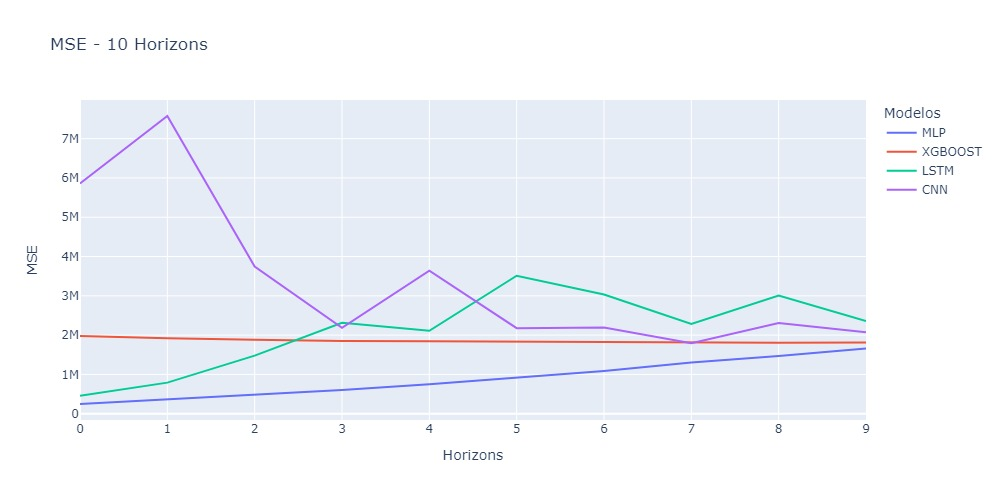

In [45]:
# Mean squared error result:
metric = 'MSE.jpg'
image_path = 'imagens/{}'.format(metric)
print_image(image_path)

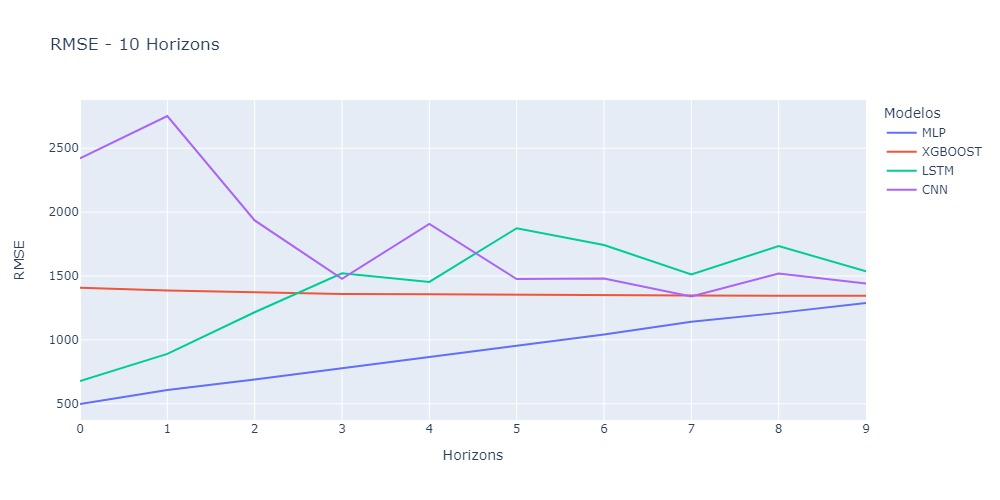

In [46]:
# Root mean squared error result:
metric = 'RMSE.jpg'
image_path = 'imagens/{}'.format(metric)
print_image(image_path)

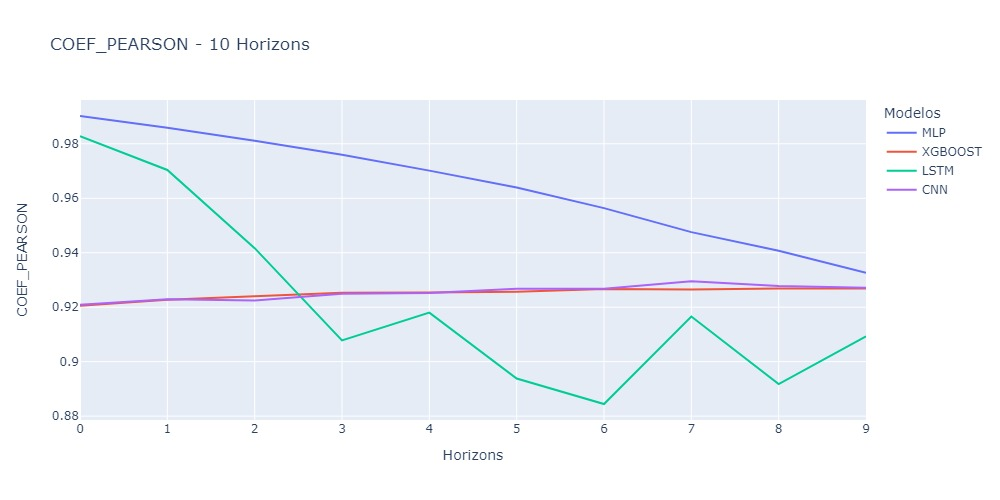

In [48]:
# Coef. Pearson result:
metric = 'COEF_PEARSON.jpg'
image_path = 'imagens/{}'.format(metric)
print_image(image_path)